In [14]:
# i want to build a model (not from scratch) that checks if an image is an MRI image or no
# i will use a pretrained model and then add some layers to it

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


In [2]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2023-12-12 20:56:25.732591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 20:56:25.733811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 20:56:25.734394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 32.00 GB
maxCacheSize: 3.99 GB



In [3]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [4]:
# Create a custom model by adding your layers on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# Display the model summary to check the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Define the paths to your train and validation datasets
train_dir = '../../../Final Project/Datasets/random_MRI_images/training'
validation_dir = '../../../Final Project/Datasets/random_MRI_images/testing'

# Set parameters for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set the batch size
batch_size = 32


In [8]:
# Create the train and validation generators
training_set = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='binary'
)

val_dataset = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2380 images belonging to 2 classes.
Found 1402 images belonging to 2 classes.


In [9]:
imgs, labels = next(training_set)

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

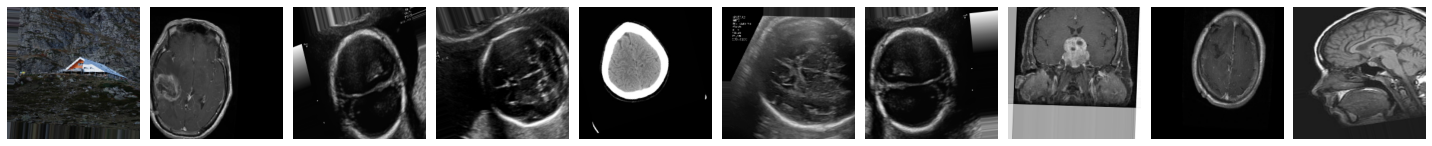

In [11]:
plotImages(imgs)

In [13]:
model.fit(training_set, epochs=4, validation_data=val_dataset)

Epoch 1/4
75/75 [==============================] - 116s 2s/step - loss: 0.0659 - accuracy: 0.9697 - val_loss: 0.0534 - val_accuracy: 0.9829
Epoch 2/4
75/75 [==============================] - 113s 2s/step - loss: 0.0643 - accuracy: 0.9714 - val_loss: 0.0448 - val_accuracy: 0.9872
Epoch 3/4
75/75 [==============================] - 116s 2s/step - loss: 0.0585 - accuracy: 0.9748 - val_loss: 0.0321 - val_accuracy: 0.9879
Epoch 4/4
75/75 [==============================] - 117s 2s/step - loss: 0.0575 - accuracy: 0.9773 - val_loss: 0.0442 - val_accuracy: 0.9886


In [17]:
index = ['MRI', 'non-MRI']

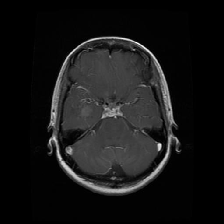

In [39]:
test_image1 = load_img('../../../Final Project/Datasets/random_MRI_images/training/mri/Te-gl_0013.jpg',target_size = (224,224))
test_image1

In [40]:
test_image1 = img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1,axis=0)
result1 = np.argmax(model.predict(test_image1/255.0),axis=1)
print(index[result1[0]])

1/1 [==============================] - 0s 65ms/step
MRI


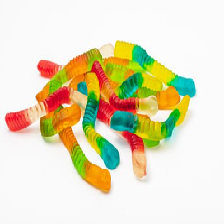

In [43]:
test_image2 = load_img('../../../Final Project/Datasets/random_MRI_images/testing/nomri/photo-1533602747409-1f3dea118ac8.jpg',
                    target_size = (224,224))
test_image2

In [44]:
test_image2 = img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2,axis=0)
result2 = np.argmax(model.predict(test_image2/255.0),axis=1)
print(index[result2[0]])

1/1 [==============================] - 0s 39ms/step
MRI


In [45]:
model.save('MRI_Detection.h5')